<img src="data/photutils_banner.svg" width=500 alt="Photutils logo">

# Photutils

- Code: https://github.com/astropy/photutils
- Documentation: http://photutils.readthedocs.org/en/stable/
- Issue Tracker:  https://github.com/astropy/photutils/issues

## Photutils capabilities:

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - Image segmentation
  - local peak finder
- Aperture photometry
- PSF photometry
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis


## In this additional notebook, we will review:

- Background and background noise estimation

---

# Local Background Subtraction in Photutils

## Preliminaries

In [1]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'viridis'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading data and error arrays from FITS files.  This is a small region from the Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [2]:
from astropy.io import fits
from astropy.wcs import WCS

sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'

hdr = fits.getheader(sci_fn)
data = fits.getdata(sci_fn)
error = fits.getdata(rms_fn)
wcs = WCS(hdr)

In [3]:
# calculate the total error:  background plus source Poisson error
from photutils.utils import calc_total_error

eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

The background in the XDF image has already been subtracted.  Let's add a background of 5 e-/s.

In [4]:
data += 5.

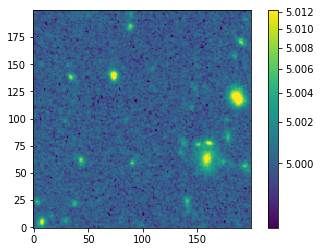

In [5]:
# display the data
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt', percent=99.5)
plt.imshow(data, norm=norm)
plt.colorbar()

## Perform aperture photometry at multiple positions

In [6]:
# define three apertures
from photutils import CircularAperture

positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

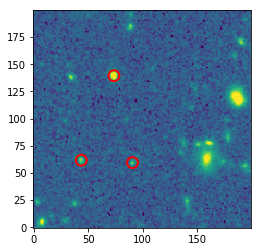

In [7]:
# plot the apertures
plt.imshow(data, norm=norm)
apertures.plot(color='red', lw=2)

In [8]:
# perform aperture photometry for the three sources
# data here includes background, so the aperture sums are *not* the source fluxes
# ideally the data array should be background subtracted before running aperture_photometry
import astropy.units as u
from photutils import aperture_photometry

unit = u.electron / u.s
phot = aperture_photometry(data, apertures, error=tot_error, unit=unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int32,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,0.00804402316102156
2,73.63,139.41,393.31410686942934,0.008166280751929555
3,43.62,61.63,392.91260683727245,0.008069761444284972


## Local background estimation

First, let's create circular and circular-annulus apertures at the same positions.

Here we're define a r=5 pixel circular aperture and a circular annulus with inner and outer radii of 10 and 15 pixels, respectively.

The circular-annulus apertures will be used for local background estimation around the sources.

In [9]:
from photutils import CircularAnnulus

positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
aper = CircularAperture(positions, r=5)
bkg_aper = CircularAnnulus(positions, r_in=10., r_out=15.)
apers = [aper, bkg_aper]

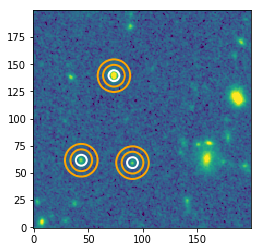

In [10]:
# plot the apertures
plt.imshow(data, norm=norm)
aper.plot(color='white', lw=2)
bkg_aper.plot(color='orange', lw=2)

### Simple local background estimation

This simple example uses the mean value in circular annulus as the background value.  We'll use the `aperture_photometry` function to calculate the pixel sum in the circular annulus, from which we can calculate the mean background value.

In [11]:
phot = aperture_photometry(data, apers)
phot.rename_column('aperture_sum_0', 'aperture_sum')
phot.rename_column('aperture_sum_1', 'annulus_sum')
phot

id,xcenter,ycenter,aperture_sum,annulus_sum
,pix,pix,,
int32,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,1963.515317740115
2,73.63,139.41,393.31410686942934,1963.5312979033984
3,43.62,61.63,392.91260683727245,1963.5120724060948


Note that the fluxes cannot be simply subtracted because the aperture areas are different.

First, calculate the mean background level (per pixel) in the annuli.

In [12]:
phot['annulus_mean'] = phot['annulus_sum'] / bkg_aper.area()
phot

id,xcenter,ycenter,aperture_sum,annulus_sum,annulus_mean
,pix,pix,,,
int32,float64,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,1963.515317740115,5.000050698479885
2,73.63,139.41,393.31410686942934,1963.5312979033984,5.000091391631533
3,43.62,61.63,392.91260683727245,1963.5120724060948,5.000042434304665


Then multiply it by the circular aperture area to get the total background in the apertures.

In [13]:
phot['aperture_bkg'] = phot['annulus_mean'] * aper.area()
phot

id,xcenter,ycenter,aperture_sum,annulus_sum,annulus_mean,aperture_bkg
,pix,pix,,,,
int32,float64,float64,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,1963.515317740115,5.000050698479885,392.70306354802307
2,73.63,139.41,393.31410686942934,1963.5312979033984,5.000091391631533,392.7062595806797
3,43.62,61.63,392.91260683727245,1963.5120724060948,5.000042434304665,392.702414481219


Now subtract the background.

In [14]:
# subtract the background
flux_bkgsub = phot['aperture_sum'] - phot['aperture_bkg']

phot['aperture_sum_bkgsub'] = flux_bkgsub
phot

id,xcenter,ycenter,aperture_sum,annulus_sum,annulus_mean,aperture_bkg,aperture_sum_bkgsub
,pix,pix,,,,,
int32,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,1963.515317740115,5.000050698479885,392.70306354802307,0.11641194517869735
2,73.63,139.41,393.31410686942934,1963.5312979033984,5.000091391631533,392.7062595806797,0.6078472887496105
3,43.62,61.63,392.91260683727245,1963.5120724060948,5.000042434304665,392.702414481219,0.210192356053426


### Custom local background subtraction

Starting with `photutils v0.3` (released Nov. 2016) one can use aperture masks to directly access the pixel values in an aperture.  This allows for advanced local background subtraction.

Aperture masks are created using the `to_mask()` method.

In [15]:
bkg_mask = bkg_aper.to_mask()

In [16]:
# bkg_mask is a list of ApertureMask objects, one for each aperture position
bkg_mask

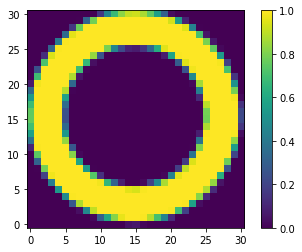

In [17]:
# Let's plot the first one.
plt.imshow(bkg_mask[0])
plt.colorbar()

The mask values are between 0 and 1, indicating the overlap fraction of the aperture on the pixel grid.  The fractional values in the mask above are because the default overlap method is "exact".  We can use other methods, e.g. "center", where pixels are either completely in or out of the aperture depending on whether the pixel center is in or out of the aperture.

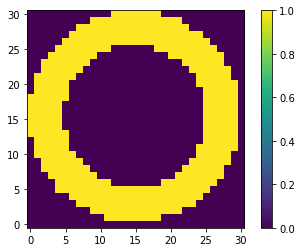

In [18]:
bkg_mask = bkg_aper.to_mask(method='center')
plt.imshow(bkg_mask[0])
plt.colorbar()

The values in the above mask are either 0 or 1.  **This the type of mask that I strongly recommend you use for local background estimation.**

One could use the "exact" mask, but it requires using statistical functions that can handle partial-pixel weights.  That introduces a lot of unnecessary complexity when the aperture is simply being used to estimate the local background -- whole pixels are fine, assuming you have a sufficient number of them.

We can now use the `ApertureMask` `multiply` method to get the values of the mask multiplied to the data.  Since the mask values are 0 or 1, this is simply the data values within the annulus aperture:

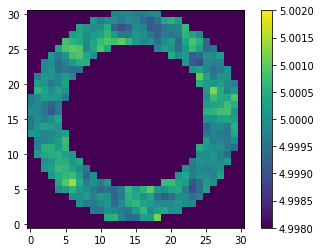

In [19]:
bmask = bkg_mask[0]   # first aperture
data1 = bmask.multiply(data)
plt.imshow(data1, vmin=4.998, vmax=5.002)
plt.colorbar()

From this 2D array, you can extract a 1D array of data values (e.g. if you don't care about their spatial positions, which is probably most cases).  You can then use your favorite statistical estimator on this data to estimate the background level.

In [20]:
# extract the data within the aperture
# data_values is a 1D ndarray
idx = bmask.data > 0
aper_data = data1[idx]
aper_data.shape

(393,)

In [21]:
# to calculate the mask weights (e.g. needed for method='exact')
# for method='center' the weights will all be 1.
weights = bmask.data[idx]
weights.shape

(393,)

(array([ 3.,  5.,  7., 14., 23., 33., 33., 44., 47., 49., 40., 26., 25.,
        17., 12.,  8.,  4.,  1.,  1.,  1.]),
 array([4.99892569, 4.99905283, 4.99917998, 4.99930713, 4.99943428,
        4.99956143, 4.99968858, 4.99981573, 4.99994287, 5.00007002,
        5.00019717, 5.00032432, 5.00045147, 5.00057862, 5.00070577,
        5.00083292, 5.00096006, 5.00108721, 5.00121436, 5.00134151,
        5.00146866]),
 <a list of 20 Patch objects>)

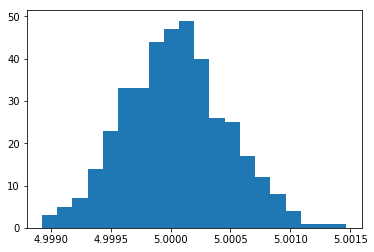

In [22]:
# distribution of data values in the annulus aperture
plt.hist(aper_data, bins=20)

In [23]:
# simple mean and median
np.mean(aper_data), np.median(aper_data)

(5.000041812430811, 5.0000410079956055)

In [24]:
# sigma-clipped mean and median
from astropy.stats import sigma_clipped_stats
mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(aper_data)
mean_sigclip, median_sigclip

(5.000038172517504, 5.00003981590271)

In [25]:
# biweight "mean"
from astropy.stats import biweight_location
biweight_location(aper_data)

5.000036192309838

These background estimates represent the background *per pixel* for the first source only.  Like the first simple local background example, be sure to calculate the total background with the circular aperture before subtracting.  The area of the 'exact' circular aperture that we used for photometry is returned by its `area()` method.

In [26]:
# total background in circular aperture of the first source
# estimated using a sigma-clipped median in the circular annulus
bkg_total = aper.area() * median_sigclip
bkg_total

392.7022088324104

In [27]:
# now subtract the background from the first source
phot['aperture_sum'][0] - bkg_total

0.11726666079135839

In [28]:
# which is close to our first simple local background estimate (simple mean)
# because there were not any outliers in the background annulus
phot['aperture_sum_bkgsub'][0]

0.11641194517869735

## Putting it all together

Above was a very pedagogical description of the underlying methods for local background subtraction for a single source.

However, it's quite straightforward to do this for all of the sources in just a few lines of code.  For this example, we'll again use the sigma-clipped median of the pixels in the background annuli for the background estimates of each source.

In [29]:
# these are the sigma-clipped median values in each of the background annuli
bkg_median = []
bkg_mask = bkg_aper.to_mask(method='center')
for mask in bkg_mask:
    aper_data = bmask.multiply(data)
    aper_data = aper_data[mask.data > 0]
    
    # perform a sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
    
bkg_median = np.array(bkg_median)
bkg_median

array([5.00003982, 5.00003982, 5.00003719])

In [30]:
# correct for aperture area, subtract the background, and add table columns
# I left the simple mean columns in the table for comparison.
phot['annulus_median'] = bkg_median
phot['aperture_bkg2'] = bkg_median * aper.area()
phot['aperture_sum_bkgsub2'] = phot['aperture_sum'] - phot['aperture_bkg2']
phot

id,xcenter,ycenter,aperture_sum,annulus_sum,annulus_mean,aperture_bkg,aperture_sum_bkgsub,annulus_median,aperture_bkg2,aperture_sum_bkgsub2
,pix,pix,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,392.81947549320176,1963.515317740115,5.000050698479885,392.70306354802307,0.11641194517869735,5.00003981590271,392.7022088324104,0.11726666079135839
2,73.63,139.41,393.31410686942934,1963.5312979033984,5.000091391631533,392.7062595806797,0.6078472887496105,5.00003981590271,392.7022088324104,0.611898037018932
3,43.62,61.63,392.91260683727245,1963.5120724060948,5.000042434304665,392.702414481219,0.210192356053426,5.00003719329834,392.70200285354485,0.21060398372759437


## A few more things about `ApertureMask`

Cutouts of each source using the minimal bounding box of each aperture can be obtained using the `cutout()` method.

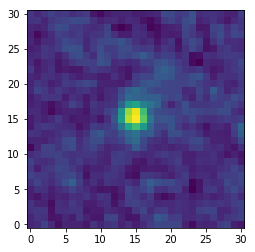

In [31]:
plt.imshow(bmask.cutout(data))

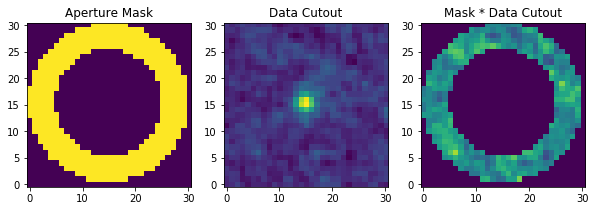

In [32]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(bmask)
plt.title('Aperture Mask')

plt.subplot(1, 3, 2)
plt.title('Data Cutout')
plt.imshow(bmask.cutout(data))

plt.subplot(1, 3, 3)
plt.title('Mask * Data Cutout')
plt.imshow(bmask.multiply(data), vmin=4.998, vmax=5.002)

One can also plot the location of the mask on the original data using the `to_image()` method.

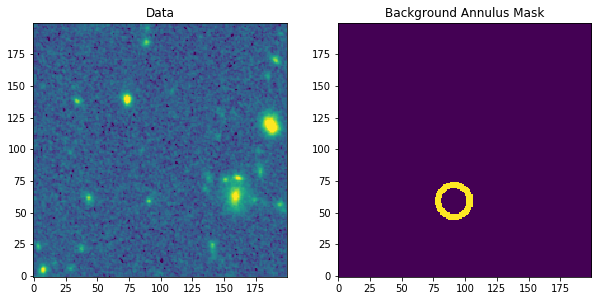

In [33]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Data')
plt.imshow(data, norm=norm)

plt.subplot(1, 2, 2)
plt.title('Background Annulus Mask')
plt.imshow(bmask.to_image(data.shape))

We can also use the `bbox` attribute to show the extent of the annulus mask in the image.

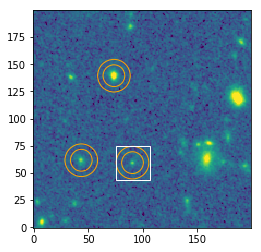

In [34]:
plt.imshow(data, norm=norm)
bkg_aper.plot(color='orange')

ax = plt.gca()
ax.add_patch(bmask.bbox.as_patch(facecolor='none', edgecolor='white'))